In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import torch
import nngls
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
def f5(X): return (10*np.sin(np.pi*X[:,0]*X[:,1]) + 20*(X[:,2]-0.5)**2 + 10*X[:,3] +5*X[:,4])/6

sigma = 1
phi = 3
tau = 0.01
theta = torch.tensor([sigma, phi / np.sqrt(2), tau])

p = 5; funXY = f5

n = 1000
nn = 20
batch_size = 50

X, Y, coord, cov, corerr = nngls.Simulation(n, p, nn, funXY, theta, range=[0, 1])

data = nngls.make_graph(X, Y, coord, nn)

data_train, data_val, data_test = nngls.split_data(X, Y, coord, neighbor_size = 20, 
                                                   test_proportion = 0.2)


In [23]:
start_time = time.time()
mlp = torch.nn.Sequential(
    torch.nn.Linear(p, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 1)
)
nn_model = nngls.nn_train(mlp, lr =  0.01, min_delta = 0.001)
training_log = nn_model.train(data_train, data_val, data_test)
theta0 = nngls.theta_update(torch.tensor([1, 1.5, 0.01]), mlp(data_train.x).squeeze() - data_train.y, data_train.pos, neighbor_size = 20)
mlp = torch.nn.Sequential(
    torch.nn.Linear(p, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 1)
)
model = nngls.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp, theta=torch.tensor(theta0))
nngls_model = nngls.nngls_train(model, lr =  0.01, min_delta = 0.001)
training_log = nngls_model.train(data_train, data_val, data_test,
                                 Update_init = 10, Update_step = 10)
end_time = time.time()

0
1
INFO: Early stopping counter 1 of 10
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
INFO: Early stopping counter 1 of 10
20
21
INFO: Early stopping counter 1 of 10
22
23
24
25
26
INFO: Early stopping counter 1 of 10
27
INFO: Early stopping counter 2 of 10
28
29
INFO: Early stopping counter 1 of 10
30
INFO: Early stopping counter 2 of 10
31
INFO: Early stopping counter 3 of 10
32
33
34
INFO: Early stopping counter 1 of 10
35
36
37
38
39
40
41
INFO: Early stopping counter 1 of 10
42
43
44
45
INFO: Early stopping counter 1 of 10
46
47
INFO: Early stopping counter 1 of 10
48
INFO: Early stopping counter 2 of 10
49
50
INFO: Early stopping counter 1 of 10
51
INFO: Early stopping counter 2 of 10
52
INFO: Early stopping counter 3 of 10
53
INFO: Early stopping counter 4 of 10
54
INFO: Early stopping counter 5 of 10
55
Epoch 00056: reducing learning rate of group 0 to 5.0000e-03.
INFO: Early stopping counter 6 of 10
56
INFO: Early stopping counter 7 of 10
57
58
INFO: Early stopping counter 1 

/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/nngls/utils.py:468: RuntimeWarning: invalid value encountered in sqrt
  decor_res = np.sqrt(np.reciprocal(F_i)) * np.dot(I_B_i, residual[id])
/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/nngls/utils.py:469: RuntimeWarning: invalid value encountered in log
  term1 += np.log(F_i)


0
1
2
INFO: Early stopping counter 1 of 10
3
4
5
6
7
INFO: Early stopping counter 1 of 10
8
9
10
Theta updated from
[0.74820479 6.27543505 0.09468975]


/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/nngls/utils.py:468: RuntimeWarning: invalid value encountered in sqrt
  decor_res = np.sqrt(np.reciprocal(F_i)) * np.dot(I_B_i, residual[id])
/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/nngls/utils.py:469: RuntimeWarning: invalid value encountered in log
  term1 += np.log(F_i)


to
[0.77001942 6.13413933 0.12717034]
11
INFO: Early stopping counter 1 of 10
12
13
14
15
16
17
INFO: Early stopping counter 1 of 10
18
19
INFO: Early stopping counter 1 of 10
20
Theta updated from
[0.77001942 6.13413933 0.12717034]


/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/nngls/utils.py:468: RuntimeWarning: invalid value encountered in sqrt
  decor_res = np.sqrt(np.reciprocal(F_i)) * np.dot(I_B_i, residual[id])
/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/nngls/utils.py:469: RuntimeWarning: invalid value encountered in log
  term1 += np.log(F_i)


to
[0.79628902 5.69426881 0.03068326]
INFO: Early stopping counter 2 of 10
21
INFO: Early stopping counter 3 of 10
22
INFO: Early stopping counter 4 of 10
23
INFO: Early stopping counter 5 of 10
24
25
26
INFO: Early stopping counter 1 of 10
27
INFO: Early stopping counter 2 of 10
28
INFO: Early stopping counter 3 of 10
29
INFO: Early stopping counter 4 of 10
30
Theta updated from
[0.79628902 5.69426881 0.03068326]


/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/nngls/utils.py:468: RuntimeWarning: invalid value encountered in sqrt
  decor_res = np.sqrt(np.reciprocal(F_i)) * np.dot(I_B_i, residual[id])
/Users/zhanwentao/Documents/Abhi/NN/NN-GLS/nngls/utils.py:469: RuntimeWarning: invalid value encountered in log
  term1 += np.log(F_i)


to
[0.79855609 5.36033083 0.01600333]
INFO: Early stopping counter 5 of 10
31
Epoch 00032: reducing learning rate of group 0 to 5.0000e-03.
INFO: Early stopping counter 6 of 10
32
INFO: Early stopping counter 7 of 10
33
INFO: Early stopping counter 8 of 10
34
INFO: Early stopping counter 9 of 10
35
INFO: Early stopping counter 10 of 10
INFO: Early stopping
End at epoch35


In [24]:
# Compute benchmark MSE (always predicting the mean)
benchmark_preds = torch.full(data_test.y.shape, data_train.y.mean())
benchmark_mse = torch.nn.functional.mse_loss(benchmark_preds, data_test.y)
print(f'Benchmark MSE: {benchmark_mse:.3f}')

Benchmark MSE: 1.521


In [25]:
print(f"\rRunning time: {end_time - start_time} seconds")

Running time: 22.43343424797058 seconds


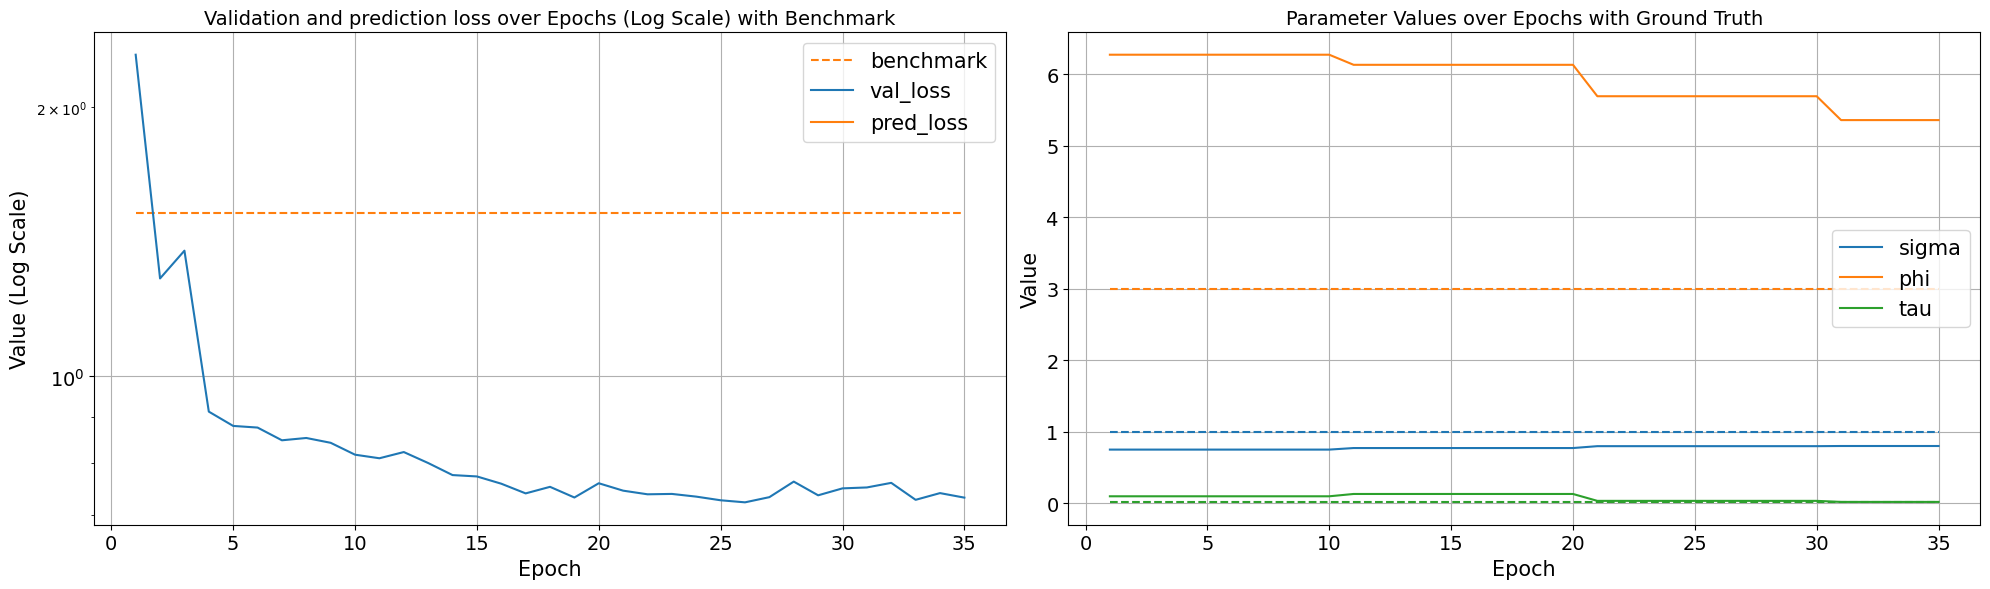

In [26]:
epoch = len(training_log["val_loss"])
training_log["epoch"] = list(range(1, epoch + 1))
training_log["pred_loss"] = None
training_log = pd.DataFrame(training_log)

# Melting the dataframe to make it suitable for seaborn plotting
training_log_melted = training_log[["epoch", "val_loss", "pred_loss"]].melt(id_vars='epoch', var_name='Variable', value_name='Value')

# Finding the color used for the 'metric' in the plot
palette = sns.color_palette()
metric_color = palette[1]  # Assuming 'metric' is the second line in the plot

# Plotting with seaborn
# Creating two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
benchmark_line = axes[0].hlines(y=benchmark_mse, xmin=1, xmax=epoch, color=metric_color, linestyle='--', label='benchmark')
sns.lineplot(ax=axes[0], data=training_log_melted, x='epoch', y='Value', hue='Variable', style='Variable', markers=False, dashes=False)

axes[0].set_title('Validation and prediction loss over Epochs (Log Scale) with Benchmark', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=15)
axes[0].set_ylabel('Value (Log Scale)', fontsize=15)
axes[0].set_yscale('log')
axes[0].legend(prop={'size': 15})
axes[0].tick_params(labelsize=14)
axes[0].grid(True)

# Second plot (sigma, phi, tau)
kernel_params_melted = training_log[["epoch", "sigma", "phi", "tau"]].melt(id_vars='epoch', var_name='Variable', value_name='Value')
ground_truth = {'sigma': sigma, 'phi': phi, 'tau': tau}
sns.lineplot(ax=axes[1], data=kernel_params_melted, x='epoch', y='Value', hue='Variable', style='Variable', markers=False, dashes=False)
palette = sns.color_palette()
for i, (param, gt_value) in enumerate(ground_truth.items()):
    axes[1].hlines(y=gt_value, xmin=1, xmax=epoch, color=palette[i], linestyle='--')
axes[1].set_title('Parameter Values over Epochs with Ground Truth', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=15)
axes[1].set_ylabel('Value', fontsize=15)
axes[1].legend(prop={'size': 15})
axes[1].tick_params(labelsize=14)
axes[1].grid(True)

plt.tight_layout()

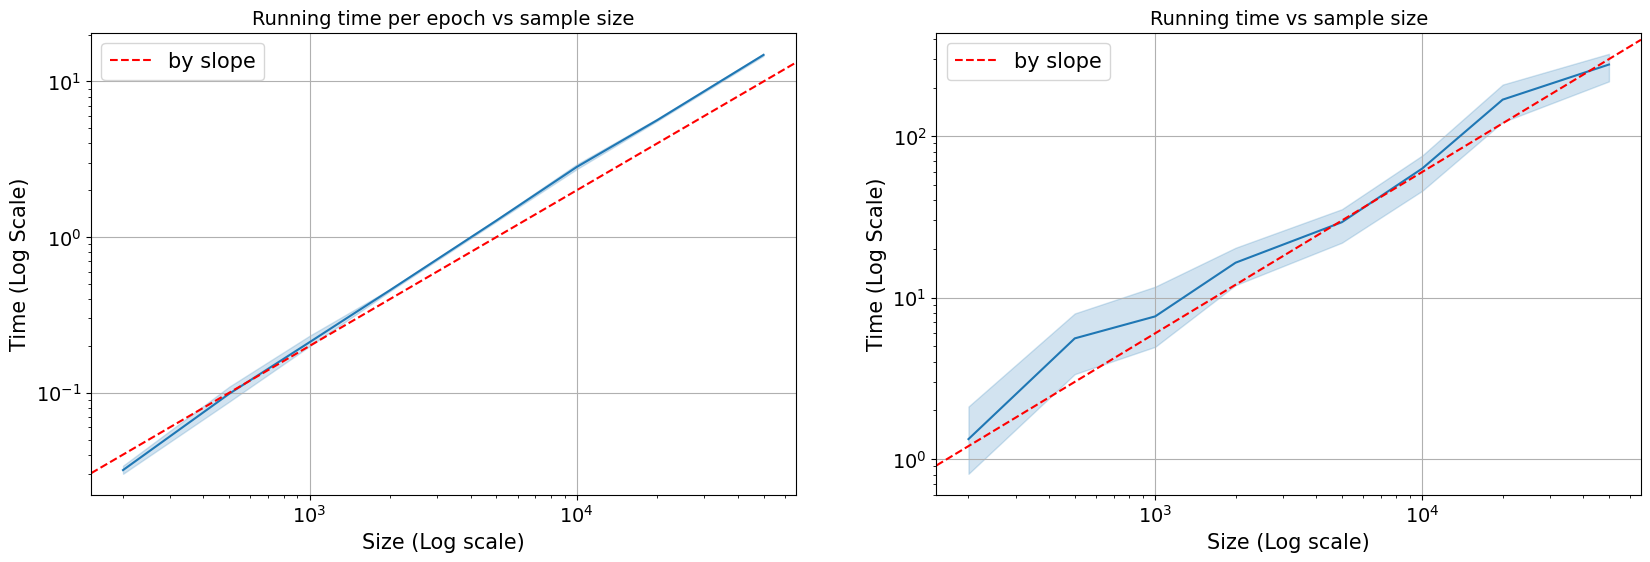

In [27]:
time = pd.read_csv("./running_time.csv")
time['Time per epoch'] = time['time']/time['epoch']

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.lineplot(ax=axes[0], data=time, x='size', y='Time per epoch', markers=False, dashes=False)
axes[0].set_title('Running time per epoch vs sample size', fontsize=14)
axes[0].axline((200, 0.04), slope=1, color='red', label='by slope', linestyle='--')
axes[0].set_xlabel('Size (Log scale)', fontsize=15)
axes[0].set_ylabel('Time (Log Scale)', fontsize=15)
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].legend(prop={'size': 15})
axes[0].tick_params(labelsize=14)
axes[0].grid(True)

sns.lineplot(ax=axes[1], data=time, x='size', y='time', markers=False, dashes=False)
axes[1].set_title('Running time vs sample size', fontsize=14)
axes[1].axline((200, 1.2), slope=1, color='red', label='by slope', linestyle='--')
axes[1].set_xlabel('Size (Log scale)', fontsize=15)
axes[1].set_ylabel('Time (Log Scale)', fontsize=15)
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].legend(prop={'size': 15})
axes[1].tick_params(labelsize=14)
axes[1].grid(True)
#axes[1].set_yscale('log')